(supervised_learning)=
# Supervised Learning

By supervision we mean human supervision.
Supervised learning works with labeled (annotated) data.
The labels must be made manually by people, and this can require a lot of work for large data sets.
The labels are annotations that describes the data.

In our case, the data will be text documents.
One common task is classification where the goal is to split the data into classes, for example by topic.
Documents can be classified for example by type, topic, language, or jurisdiction.

## Visualizing Classes

To get an idea of how classification works, we'll first look at a simple example that doesn't involve text.
We can simulate a data set with only two features, so that they can be visualized graphically.
Real data sets rarely have so few features and are harder to visualize.

First, we import some functions we will need.
- scikit-learn (`sklearn`) is a library for machine learning.
- matplotlib is a library for plotting and visualizing results.

We also import some functions from `sklearn` that we'll use further below.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
# configure matplotlib
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

Then, we use sklearn to make a simulated or synthetic data set.

In [2]:
data, labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                   random_state=2, n_clusters_per_class=1)

Now, we can plot the data points in a *scatter plot*.
The two classes have different colors.

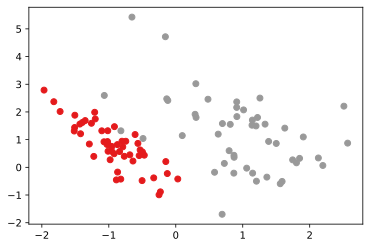

In [3]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.Set1);

```{admonition} Interpreting the Data
:class: tip
While this data set is artificial, real world data could look like this.
The data points can represent the outcomes of criminal cases, where the gray points are cases that resulted in a prison sentence, while the red points resulted in probation.
The x-axis can measure the number of criminal offenses, while the y-axis measures the seriousness of the offenses.
```

In the plot above, the two classes are grouped and separated quite nicely.
This makes learning easier.
If the classes overlap, they are harder to distinguish.

The goal in classification is to *predict* the class of new data points.
The assumption is that new points will have the same class as other nearby points.
The classifier must find the boundary between the classes.
The classifier learns this class boundary from the training data.

:::{admonition} Decision Boundaries
We call the "border" between the classes the *decision boundary*.
We can see that these classes are nearly *linearly separable*, which means that we can draw a straight line that separates the two classes.

Some simple machine learning algorithms can only separate data linearly, while more powerful algorithms, such as *neural networks*, can make arbitrary decision boundaries.
:::

:::{admonition} Outliers
At least one of the gray points lie within the red "area".
Without this point, the data would be linearly separable.
This point seems to be a statistical *outlier*.
An outlier is an extreme value that differs significantly from other values.
There are a couple of gray points at the top of the figure which also seem to be outliers.
:::

## Class Labels

Below is an example of a document which is a contract.
The label (document type) is not part of the document.
If the documents are stored as tabular data, the labels are in one or more separate columns.
The first column could contain the document while the second column could contain the label.

```
Agreement

1. Introduction: The lender is Bank Cred AS.
The borrower is the person or persons (borrower and co-applicant) who apply
for and are granted a loan with this Agreement.
Payment: The credit is paid to the account number the Borrower states.

2. Repayment: The Borrower repays the loan amount at fixed term amounts, including 
interest and term fees (i.e. annuity loans) as specified in the Loan Agreement.

3. Late Payment Interest: In the event of late payment, late payment interest accrues
at the interest rate determined in accordance with the Act relating to Interest on
Overdue Payments.

Signature Place/date: Oslo, 08.08.2021
For Bank Cred AS Bank adviser Maria Wilson
Name: Christopher Thomson Borrower
```

This document could have different labels/classes depending on our application needs.
For example, if we're interested in document types, it could be labeled "contract".
If we're classifying documents by language, it would be labeled "English".

## Loading Text from Files

We will continue working with cases from the ECHR-OD data set.
Our task is to predict the conclusion from the facts of the case.
We will limit ourselves to Article 6, since multiple classes are harder to predict than a single class.

First, we must define some functions to read and process the data.
The details of these functions aren't central here, but you can click the plus sign to see them.

In [4]:
import json

def read_json_file(filename):
    'Read json data from a file'
    with open(filename, 'r') as file:
        text_data = file.read()
        return json.loads(text_data)


def json_to_text(doc, include_headings=True):
    '''
    Extract content text from JSON tree structure.
    https://echr-opendata.eu/doc/

    Params:
        doc: ECHR JSON element
        include_headings: Whether to include the section headings
    '''
    def json_to_text_helper(doc):
        result = []
        if not doc['elements'] or include_headings:
            result.append(doc['content'].strip().replace('\xa0', ' '))  # replace non-breaking space
        for element in doc['elements']:
            result.extend(json_to_text_helper(element))
        return result
    return '\n'.join(json_to_text_helper(doc))


def get_facts(case):
    'Get the "Facts" section of the case text'
    content = case['content']
    docname = list(content)[0]
    document = content[docname]

    for section in document:
        if section.get('section_name') == 'facts':
            return json_to_text(section)
    return ''


def get_conclusion(case, article):
    '''
    Get the conclusion of the case regarding the specified article
    '''
    conclusions = case['conclusion']
    for conclusion in conclusions:
        if conclusion.get('article', '').startswith(article):
            return conclusion['type']
    return 'no conclusion'

Now, we can read the json data from the file.

In [5]:
cases = read_json_file('cases-2000.json')

We make two lists, one containing the documents and another containing the labels.

In [6]:
documents = [get_facts(case) for case in cases]
labels = [get_conclusion(case, '6') for case in cases]

We can check that we have the same number of documents and labels:

In [7]:
print(f'Number of documents: {len(documents)}, labels: {len(labels)}')

Number of documents: 2000, labels: 2000


## Vectorizing Text

To use text documents in machine learning, they must first be vectorized.
We'll use a simple Bag of Words representation, which is provided by scikit-learn's `CountVectorizer()`.
This function has some parameters:
- `max_features=20000` specifies the number of different words to include.
`CountVectorizer()` includes the words with the most occurrences, and ignores rare words.
- `stop_words='english'` means that *function words* like "the" and "in" should be ignored.
Stop words carry little meaning, so it is often best to ignore them.
- `lowercase=True` means that all words are converted to lowercase.
If we don't do this, all the words at the start of sentences with capital letters will be treated as separate words.
- `binary=False` means that we count the number of words.
`binary=True` means that we only record whether a word is present with 1 or 0, in a *binary* vector.

In [8]:
text_vectorizer = CountVectorizer(
    max_features=20000,
    stop_words='english',
    lowercase=True,
    binary=False,
)

With the vectorizer made, we can use it to transform the data:

In [9]:
input_features = text_vectorizer.fit_transform(documents)

The string labels must also be turned into numbers.
We do this with `LabelEncoder()`, which returns an integer for each label.

In [10]:
label_vectorizer = LabelEncoder()
labels_vector = label_vectorizer.fit_transform(labels)

## Inspecting the Data
We can do some manual checks, to see that everything looks okay.
First, let's see how many examples we have of each class.

label counts:


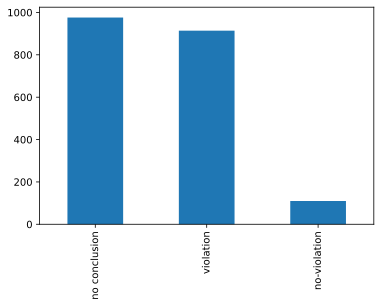

In [11]:
import pandas as pd
print('label counts:')
pd.Series(labels).value_counts().plot(kind='bar');

```{admonition} Imbalanced Data
:class: warning
The plot shows that our data clearly are imbalanced, with many more conclusions of "violation" than "no violation".
Fewer "no violation" examples to learn from can lead to difficulties with learning and bias in the learned function.
We might consider rebalancing the data by ignoring some of the cases where a violation was found.
```

```{note}
Even though we are only looking at article 6, we still get 3 classes.
Cases can have 3 possible conclusions for article 6: "violation", "no-violation" or "no conclusion",
i.e. article 6 is not relevant for the case.
We would get better results if we filtered out the cases that are not relevant.
This is left as an exercise.
```

We can also look at the vocabulary of the vectorizer.
If this number is lower than `max_features`, it means that our documents contain fewer than this many unique words.

In [12]:
print('vocabulary size:', len(text_vectorizer.get_feature_names()))

vocabulary size: 20000


We can list some of the words in the vocabulary:

In [13]:
print('vocabulary sample:', text_vectorizer.get_feature_names()[10000:10010])

vocabulary sample: ['join', 'joinder', 'joined', 'joining', 'joint', 'jointly', 'joints', 'jointstock', 'joke', 'jokingly']


## Splitting the Data
We want the learned function to be useful on new data.
Therefore, we want to be able to check that it generalizes to new data.
To do this, we must put aside some of the data to use for testing after the training is completed.
We can use scikit-learn's function `train_test_split()` to split our data set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(input_features, labels_vector,
                                                    test_size=0.3,
                                                    random_state=0)

print('Training examples after split:', X_train.shape[0])

Training examples after split: 1400


:::{admonition} X and y
Above, we use "X" and "y" instead of input and output/labels in the variable names.
This is a common convention, probably for conciseness.
If you prefer, you can use longer names, such as `input_train, input_test, labels_train, labels_test`.
:::

## Making a Classifier
Scikit-learn has many different classifiers, but we will use a simple neural network called `MLPClassifier()`.
This is a Multilayer perceptron (MLP) which is an artificial neural network with multiple layers.
`MLPClassifier()` has many parameters, but we only need to specify these:
- `max_iter=1000` is the maximum number of iterations to run
- `early_stopping=True` which means that the algorithm stops if new iterations doesn't improve the function, i.e. the learning is no longer effective.
We use early stopping both to avoid wasting resources and to avoid *overfitting* the function to our data.
Overfitting means that the function doesn't generalize well to new data.

In [15]:
classifier = MLPClassifier(
    # hidden_layer_sizes=(100,),
    max_iter=1000,
    early_stopping=True)

## Training the Classifier
Now, we can train our neural network on the training data.

In [16]:
classifier.fit(X_train, y_train)

MLPClassifier(early_stopping=True, max_iter=1000)

```{admonition} Training versus Fitting
With some machine learning methods we say that we are *fitting* a function to the data,
but with neural networks it is more common to say that we are *training* the network on the data.
As you can see above, in scikit-learn the training function is called `fit()`.
```

## Monitoring Learning
We can plot a learning curve to see how the learning progresses with each iteration.
Here, the x-axis shows the iterations, and the y-axis shows the *loss*, which is the deviation from the desired output.
Because we use early stopping, the algorithm halts when the curve flattens.

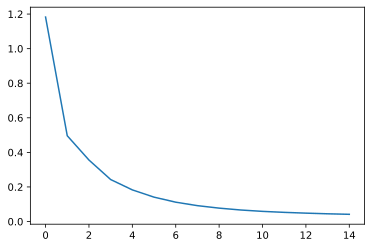

In [17]:
plt.plot(classifier.loss_curve_)
plt.show()

## Testing the Classifier
After the training, we should test how the classifier works with new data.
The simplest but not very informative way is an overall accuracy score.

In [18]:
score = classifier.score(X_test, y_test)
print(f'score: {score:.2f}')

score: 0.78


The score is around 0.78, i.e. around 78%, which seems quite good.
However, let's look at the details of how the classifier performs for the different classes.

First, we run the test data through the classifier to get the predicted labels:

In [19]:
y_predicted = classifier.predict(X_test)

Then, we can make a classification report.
This is done by comparing the predicted labels in `y_predicted`
with the correct labels in `y_test`.

In [20]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       290
           1       0.22      0.05      0.09        37
           2       0.75      0.86      0.80       273

    accuracy                           0.78       600
   macro avg       0.60      0.57      0.57       600
weighted avg       0.76      0.78      0.77       600



This report shows the *precision*, *recall*, and *F1-score* for the classes (see definitions below).
The scores for the two largest classes, 0 and 2, are okay.
But the recall for the smallest class, "no violation", is only around 10%.
This means that the function only finds around 10% of the "no violation" cases in the test data.
This score is very low, and shows that our model is useless for predicting the results of cases.


```{admonition} Precision and Recall
- Precision measures how many of the items the function assigns to a class belongs there.
- Recall measures how many true members of a class were found or "recalled".
- F1-score is the harmonic mean of recall and precision.
```

```{admonition} Varying Results
:class: warning
Most machine learning methods are *nondeterministic*, and this is also true for neural networks.
That a program is nondeterministic means that if we execute it twice on the same data,
we won't necessarily get the same results.
There is an amount of *randomness* involved.
Neural networks are initialized randomly, and the order of the training data is also random.
Two neural networks that are trained on the same data can perform differently.
Therefore, it is good practice to do the training multiple times and use the model that generalizes best.

In our case, the code in this notebook can yield a recall between 5% and 15% for class 1 in the report above.
There are only 37 "no violation" cases, as listed in the "Support" column of the table.
Therefore, a change in a single "no violation" conclusion gives a change in the percent-score of 2.7.
```

## Improving the Results
Our results so far aren't very good.
However, there are some improvements we can make that will probably yield better results.

### Binary Classification
We attempted classification with three classes: "violation", "no-violation" and "no conclusion".
Classification with only two classes (binary classification) is simpler and should give better results.
Therefore, we should filter out the cases with no conclusion.
If we need a way to determine whether an article is relevant for a case, it would probably be better to train a separate classifier for this task.

### More Data
So far, we have only used a small excerpt of the full ECHR-OD data set.
Generally, more data should give better results.
Therefore, we should use or gather as much data as possible when training machine learning algorithms.

### Changing the Model
We have used a simple Bag of Words representation which ignores much of the information in the documents, especially the order of the words.
We also use a quite simple neural network.
We would probably get better results using a more advanced neural network that uses more of the information in the documents.